# Spirtes-Glymour-Scheines (SGS) Algorithm (Aka PC-Algorithm)

The Spirtes-Glymour-Scheines (SGS) is a constraint-based algorithm for causal discovery that uses conditional independence tests to determine the presence of causal relationships between variables. The algorithm is based on the following assumptions: 

1. The causal relationships between variables form a directed acyclic graph (DAG).
2. The variables are generated by a linear Gaussian model.
3. The conditional independence tests are reliable.

The algorithm proceeds in three main stages:

```pseudo
# Skeleton Phase
1. Start with a complete undirected graph on the set of all variables
2. For each pair of variables X and Y in the graph do the following:
    2.1. If X and Y are conditionally independent given some subset of the remaining variables, then remove the edge between X and Y
    
# V-Structure Phase
3. For each pair of non-adjacent variables X and Y, do the following:
    3.1. If there exists a variable Z such the both X -> Z and Y -> Z exist in the graph, add a directed edge X -> Y if there is no subset of remaining variables that X is conditionally independent of Y.

# Orientation Phase
4. While there exists directed edges that can be oriented do the following:
    4.1. For each pair of variables X, Y where X - Y is an edge in the graph and Y - Z is a directed edge for some variable Z, orient X -Y as X -> Y if not orienting it in that way would create a new v-structure that is not justified by the data.
    4.2. For each pair of variables X, Y where X - Y is an edge in the graph and X - Z is a directed edge for some variable Z, orient X - Y as X -> Y if not orienting it in that way would create a cycle.
```

## The Theory


## Implementation

In [55]:
import pandas as pd
import numpy as np
import networkx as nx

import itertools

import pingouin as pg

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

from scipy.stats import pearsonr


import os
import math
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [440]:
# list_nodes : list of strings
# nodes_to_remove : list of strings
def remove_vars_from_list(list_nodes, nodes_to_remove):
    return [node for node in list_nodes if node not in nodes_to_remove]

# given a list of variables, generates all possible subsets
# list_of_variables : list of strings
def generate_subsets( list_of_variables ):
    combinations = []
    for i in range( 1, len( list_of_variables ) + 1 ):
        combinations += list( itertools.combinations( list_of_variables, i ) )
    return combinations

def test_pairwise_independence(data : pd.DataFrame, X : str, Y : str, verbose=False):
    
    # Compute the Pearson correlation coefficient and the p-value
    corr, p_value = np.round(pearsonr(data[X], data[Y]), 4)
    
    [print(f"({X} \ind {Y}) = {corr}" ) if verbose else None]
    
    # If the p-value is larger than 0.05, we accept the null hypothesis of independence
    return p_value > 0.05

# initialize z as a list type
def test_conditional_independence(data : pd.DataFrame, X : str, Y : str, Z,  verbose=False):

    # Compute the partial correlation of x and y given  Z
    partial_corr = pg.partial_corr(data=data, x=X, y=Y, covar=Z)
    
    # this is the precision matrix.
    # this is the inverse of the covariance matrix
    [print(f"({X} \ind {Y}) | {Z} = {partial_corr}" ) if verbose else None]

    # If the p-value is larger than 0.05, we accept the null hypothesis of independence
    return partial_corr['p-val'].values[0] > 0.05

def skeleton_phase( graph : nx.classes.graph.Graph, data : pd.DataFrame, verbose=False ):

    #For each pair of variables X and Y in the graph
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            
            if node1 == node2:
                continue

            # REDUNDANT
            # Check for independent pairs
            #independent = test_pairwise_independence(data, node1, node2, verbose)
            #[print(f"\tPr({node1} || {node2}) : {independent}") if independent and verbose else None]
            #[print(f"----------------------------------------") if independent and verbose else None]
            #if independent:
            #    if graph.has_edge(node1, node2):
            #        graph.remove_edge(node1, node2)
                    
            # Check conditional independence
            # If X and Y are conditionally independent given some subset of the remaining variables, 
            # then remove the edge between X and Y 
            subsets = generate_subsets( remove_vars_from_list(list(graph.nodes()), [node1, node2]) )
            for node3 in subsets:
                
                independent = test_conditional_independence(data, node1, node2, list(node3), verbose=verbose)
                [print(f"\tPr({node1} || {node2}) | {list(node3)}: {independent}") if independent and verbose else None]
                [print(f"----------------------------------------") if independent and verbose else None]
                
                if independent:
                    if graph.has_edge(node1, node2):
                        graph.remove_edge(node1, node2)

    return graph


def v_structure_phase( graph : nx.classes.graph.Graph, data : pd.DataFrame, verbose=False ):
    
    [print("Entered v-structure phase") if verbose else None]
    
    dag = nx.DiGraph()
    [dag.add_node(node) for node in  graph.nodes()]

    # Identify all triples (X, Y, Z) that form a V-structure X -> Y <- Z
    for X in graph.nodes():
        for Y in graph.nodes():
            for Z in graph.nodes():
                
                if X == Y or X == Z or Y == Z:
                    continue
                
                if graph.has_edge(X, Z) or test_conditional_independence(data, X, Z, [Y], verbose=verbose):
                    continue
                
                if not graph.has_edge(X, Y):
                    graph.add_edge(X, Y, arrowhead='v-struct')
                    dag.add_edge(X, Y)
                
                if not graph.has_edge(Z, Y):
                    graph.add_edge(Z, Y, arrowhead='v-struct')
                
                if not dag.has_edge(Z, Y):
                    dag.add_edge( Z, Y)

    return graph, dag


def orientation_phase(graph : nx.classes.graph.Graph, dag : nx.DiGraph, verbose=False ):
    
    while True:
        
        change = False
        for edge in list(graph.edges):
            
            node1, node2 = edge
            
            # if this edge is already oriented, skip it
            if 'arrowhead' in graph[node1][node2]:
                continue
            
            # for all nodes connected to node1 that are not node2
            for node3 in graph.neighbors(node1):
                if node3 == node2 or not graph.has_edge(node1, node3):
                    continue
                
                # check if there is a v-structure connecting node1 and node3
                # then add an edge node1 -> node2
                if 'arrowhead' in graph[node1][node3] and graph[node1][node3]['arrowhead'] == 'v-struct':
                    graph.add_edge(node1, node2, arrowhead='v-struct')
                    dag.add_edge(node1, node2)
                    change = True    
                    break
                
            if change:
                continue
            
            # for all nodes connected to node1 that are not node2
            for node3 in graph.neighbors(node2):
                if node3 == node1 or not graph.has_edge(node2, node3):
                    continue
                
                if 'arrowhead' in graph[node2][node3] and graph[node2][node3]['arrowhead'] == 'v-struct':
                    graph.add_edge(node2, node1, arrowhead='v-struct')
                    dag.add_edge(node2, node1)
                    change = True
                    break
                
        # convergence reached
        if not change:
            break
    return graph, dag

def plot_skeleton( graph : nx.classes.graph.Graph, label ):
    fig, ax = plt.subplots()
    nx.draw(graph, with_labels=True, ax=ax)
    ax.set_title(label)
    plt.show()
    

def sgs( data : pd.DataFrame, verbose=False ):
    
    # start with a complete undirected graph
    graph = nx.complete_graph( data.columns )
    plot_skeleton( graph, "Initial graph" )
    
    # apply skeleton phase
    graph = skeleton_phase( graph, data, verbose )
    plot_skeleton( graph, "End of Skeleton Phase" )
    
    # apply v-structure phase
    graph, dag = v_structure_phase( graph, data, verbose )
    plot_skeleton( graph, "End of V-Structure Phase" )

    # apply orientation phase
    graph, dag = orientation_phase( graph, dag, verbose )
    plot_skeleton( dag, "End of Orientation Phase" )
    
    return graph, dag
    

## The Model

Let's suppose that the groundtruth causal graph is the following:

In [444]:
cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
cbn

(pyAgrum.BayesNet<double>@0x7fe08bd19600) BN{nodes: 4, arcs: 2, domainSize: 16, dim: 7, mem: 112o}

In [445]:
data = pd.read_csv( "data/bn_data.csv" , sep='\t')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


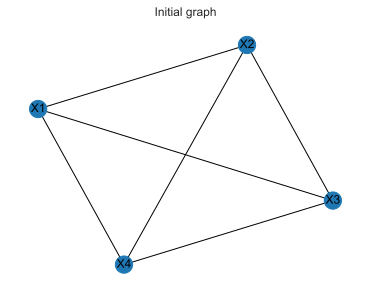

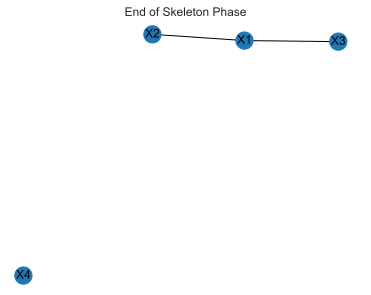

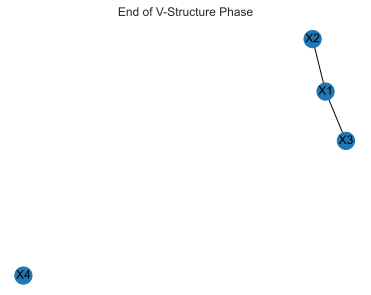

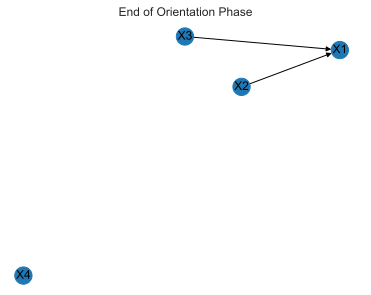

In [446]:
graph, dag = sgs( data, verbose=False )


In [467]:
### TODO
## Create an abstract class Causal_Discovery
## create a class that extends from Causal_Discovery that implements the SGS algorithm
